## HeartFailure data preprocessing

### Importing necessary libraries

In [1]:
import os
import sys
current_directory=os.getcwd()
parent_directory=os.path.dirname(current_directory)
sys.path.append(parent_directory)


In [2]:
import numpy as np
from library.generators.NextConvGeN import NextConvGeN


2024-01-31 11:57:37.199125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-31 11:57:37.199144: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
from fdc.clustering import *

In [4]:
import pandas as pd

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Importing data

In [6]:
from ucimlrepo import fetch_ucirepo 
ilpd_indian_liver_patient_dataset = fetch_ucirepo(id=225) 

In [7]:
X = ilpd_indian_liver_patient_dataset.data.features 
y = ilpd_indian_liver_patient_dataset.data.targets 

In [8]:
data=X
data['Selector']=y

In [9]:
np.random.seed(42)
data=data.sample(frac=1)

In [10]:
data.dropna(inplace=True)

In [11]:
data.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [12]:
data['Gender'].replace(['Female', 'Male'],[0,1],inplace=True)

In [13]:
data.drop_duplicates(inplace=True, ignore_index=True)

In [14]:
data['Selector'].value_counts()

1    404
2    162
Name: Selector, dtype: int64

In [15]:
data['Selector'].replace([1,2],[0,1], inplace=True)

In [16]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/IndianLiverPatients.csv")
data.to_csv(output_file_path, index=False)

In [17]:
data.drop(['Selector'],axis=1, inplace=True)

In [18]:
np.random.seed(42)
data=data.sample(frac=1)

### UMAP on entire data

In [19]:
from fdc.fdc import feature_clustering

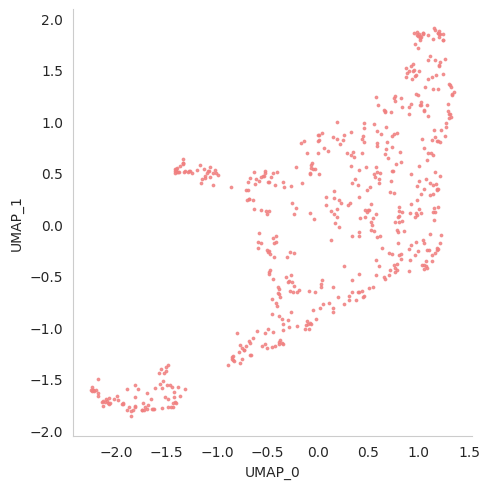

In [20]:
np.random.seed(42)
umap_emb=feature_clustering(30,0.1,'euclidean',data,True)

### Feature-type Distributed Clustering (FDC)

In [21]:
cont_list=['Age', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB','A/G Ratio']

nom_list=['Gender']

ord_list=None

target = ['Selector']


In [22]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/IndianLiverPatients.json")

In [23]:
import json

features = {
    "cont_list": cont_list,
    "nom_list": nom_list,
    "ord_list": ord_list,
    "target": target
}

with open(output_file_path, "w") as json_file:
    json.dump(features, json_file)

FDC.normalize (init): 0.00001 / 0.000s


FDC.normalize (clustering CONT): 2.63841 / 2.638s
FDC.normalize (clustering ORD): 0.00006 / 2.638s
FDC.normalize (clustering NOM): 0.00001 / 2.638s
FDC.normalize (concat): 0.00002 / 2.639s


FDC.normalize (umap 5 -> 2): 2.85534 / 5.494s
FDC.normalize (array -> DataFrame): 0.00029 / 5.494s


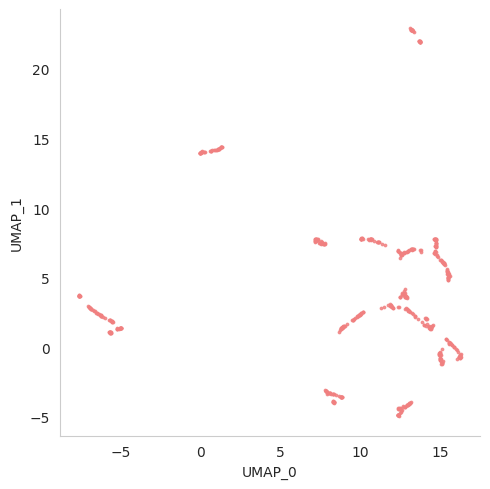

FDC.normalize (plotting): 0.39851 / 5.893s
FDC.normalize (array -> DataFrame): 0.00019 / 5.893s
FDC.normalize (total): 0.00001 / 5.893s


In [24]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
np.random.seed(42)

fdc = FDC(clustering_cont=Clustering('euclidean',30,0.01)
          , clustering_ord=Clustering(canberra_modified,30,0.01)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, ordinal=ord_list)

FDC_emb_high,FDC_emb_low = fdc.normalize(data,cont_list=cont_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

### Clustering using K-means

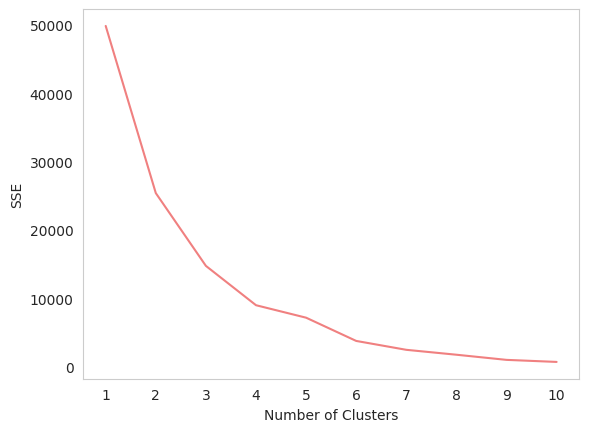

In [25]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(FDC_emb_low)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [26]:
def find_optimal_cluster(FDC_emb_low):
    silhouette_scores = []

    for n_clusters in list(range(2, 9)):
        km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)

        km.fit(FDC_emb_low)

        labels = km.labels_

        # Compute the silhouette score
        silhouette_avg = silhouette_score(FDC_emb_low, labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores

In [27]:
find_optimal_cluster(FDC_emb_low)

[0.58930933, 0.649795, 0.5050439, 0.5507401, 0.5830061, 0.61576074, 0.6787701]

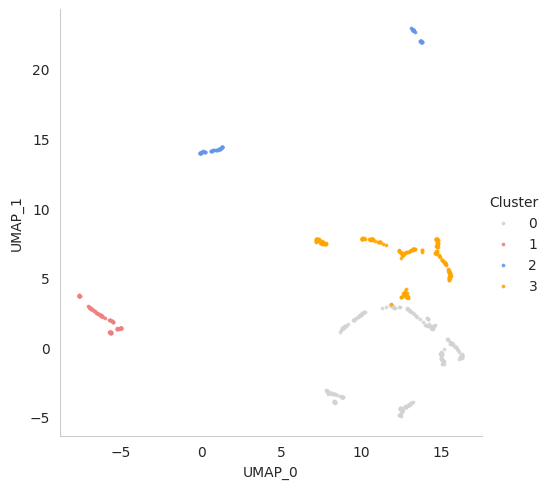

In [28]:
from fdc.clustering import *
np.random.seed(42)
clustering=Clustering(FDC_emb_low,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(4)

In [29]:
cluster_counts

array([240,  76,  64, 186])

In [30]:
data['Target']=cluster_list

In [31]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/SSIndianLiverPatients.csv")
data.to_csv(output_file_path, index=False)

In [32]:
data

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Target
539,35,1,2.0,1.1,226,33,135,6.0,2.7,0.80,3
524,60,1,2.9,1.3,230,32,44,5.6,2.0,0.50,0
234,40,1,1.9,1.0,231,16,55,4.3,1.6,0.60,0
525,74,0,1.1,0.4,214,22,30,8.1,4.1,1.00,0
489,17,1,0.9,0.3,202,22,19,7.4,4.1,1.20,0
...,...,...,...,...,...,...,...,...,...,...,...
71,72,1,0.7,0.1,196,20,35,5.8,2.0,0.50,0
106,60,1,2.0,0.8,190,45,40,6.0,2.8,0.80,3
270,70,1,1.3,0.4,358,19,14,6.1,2.8,0.80,0
435,32,1,0.7,0.2,276,102,190,6.0,2.9,0.93,3
